In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from scipy.stats import spearmanr, pearsonr, gaussian_kde

In [17]:
from pybiomart import Server

server = Server(host='http://www.ensembl.org')
dataset = server.marts['ENSEMBL_MART_ENSEMBL'].datasets['hsapiens_gene_ensembl']

# Attributes to retrieve for human homologs
attributes = [
    'ensembl_gene_id_version',  # Human Ensembl gene ID
    'external_gene_name',      # Human gene symbol
    'mmusculus_homolog_associated_gene_name' # Mouse gene symbol of homolog
    ]

homolog_results = dataset.query(attributes=attributes)
homolog_results = homolog_results.rename(columns = {'Gene stable ID version':'human_gene_id',
                                                    'Gene name': 'human_gene_name',
                                                    'Mouse gene name': 'mouse_gene_name'})
homolog_results = homolog_results[homolog_results['mouse_gene_name'].notna()]

In [18]:
# mouse data
anal2_path = "/home/mcaskey/Analyses/10XvParse/Analysis 2/gene_comparisons.csv"
# human data
anal3_path = "/home/mcaskey/Analyses/10XvParse/Analysis 3/gene_comparisons.csv"

anal2_df = pd.read_csv(anal2_path, index_col = [0])
anal2_df = anal2_df.rename(columns = {'gene_id':'mouse_gene_id',
                                      'gene_name':'mouse_gene_name'})

anal3_df = pd.read_csv(anal3_path, index_col = [0])
anal3_df = anal3_df.rename(columns = {'gene_id':'human_gene_id',
                                      'gene_name':'human_gene_name'})

In [19]:
human_df = anal3_df.merge(homolog_results, on = ['human_gene_name', 'human_gene_id'], how = 'inner')
human_df = human_df.dropna()

In [20]:
combined_df = human_df.merge(anal2_df, 
                             on=['mouse_gene_name'], 
                             how = 'inner', 
                             suffixes = ['_human', '_mouse'])
combined_df = combined_df.dropna()

In [21]:
def combine_boolcols(combined_df, colname):
    combined_df[colname] = combined_df[colname+'_human'].tolist() or combined_df[colname+'_mouse'].tolist()
    combined_df.drop(columns = [colname+'_human', colname+'_mouse'], inplace=True)
    return combined_df

In [22]:
boolcols = ['is_mito', 'is_lnc', 'is_pc', 'is_ribo']
for colname in boolcols:
    combined_df = combine_boolcols(combined_df, colname)

In [24]:
def scatter_genes(ax, combined_df, comparison, axis, axis_title, 
                  comparison_title, color, norm = None):
    
    mouse_axis = combined_df[f"{comparison}_{axis}_mouse"]
    human_axis = combined_df[f"{comparison}_{axis}_human"]

    plot = ax.scatter(mouse_axis, 
                human_axis, 
                norm = norm, 
                alpha=0.5, 
                s=50, 
                c=color, 
                cmap='viridis')
    
    ax.set_xlabel(f"Human {axis_title}")
    ax.set_ylabel(f"Mouse {axis_title}")
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_title(comparison_title)

    return plot

def cat_scatter_genes(ax, combined_df, comparison, axis, axis_title, 
                      comparison_title, label, color):
    
    mouse_axis = combined_df[f"{comparison}_{axis}_mouse"]
    human_axis = combined_df[f"{comparison}_{axis}_human"]

    plot = ax.scatter(mouse_axis, 
                human_axis, 
                s=50,
                alpha=0.5, 
                c=color,
                label=label)
    
    ax.set_xlabel(f"Human {axis_title}")
    ax.set_ylabel(f"Mouse {axis_title}")
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_title(comparison_title)

    return plot

def show_correlation(ax, combined_df, comparison, axis):
    mouse_axis = combined_df[f"{comparison}_{axis}_mouse"]
    human_axis = combined_df[f"{comparison}_{axis}_human"]

    #Calculate correlation
    pearson_r = pearsonr(mouse_axis, human_axis).correlation
    spearman_r = spearmanr(mouse_axis, human_axis).correlation
    
    x_mean = mouse_axis.mean()
    y_mean = human_axis.mean()
    x_std = mouse_axis.std()
    y_std = human_axis.std()
    CCC_r = 2 * pearson_r * x_std * y_std / (x_std**2 + y_std**2 + (x_mean - y_mean)**2)    

    maximum = max(max(mouse_axis), max(human_axis))
    ax.plot([0, maximum], [0, maximum], color='black', linestyle='--', linewidth=1.5)  # y=x line

    # Add plot annotations
    textstr = '\n'.join((
    r'$\mathrm{r}=%.2f$' % (pearson_r, ),
    r'$\rho=%.2f$' % (spearman_r, ),
    r'$\rho_C=%.2f$' % (CCC_r, ),))
    ax.text(0.05, 0.85, textstr, transform = ax.transAxes, fontsize = 12)

    return

In [29]:
def comparisonPlotter(combined_df, comparisons, axis, axis_title, 
                      comparison_titles, norm, colors, metric_name):
    
    fig, axs = plt.subplots(1, 4, figsize = (25, 5))

    for ax, comparison, color, title in zip(axs, comparisons, colors, comparison_titles):
        plot = scatter_genes(ax, 
                            combined_df,
                            comparison,
                            axis,
                            axis_title,
                            title,
                            color, 
                            norm=norm)
        show_correlation(ax, combined_df, comparison, axis)

    fig.colorbar(plot, label = metric_name)

    plt.tight_layout()
    plt.show()

In [67]:
def compareByDensity(combined_df, comparisons, axis, 
                     axis_title, titles, log_metric = False):
    
    c_values = []
    for comparison in comparisons:
        if log_metric:
            xy = np.vstack([np.log(combined_df[f"{comparison}_{axis}_mouse"].to_numpy().flatten() + 1e-12), 
                            np.log(combined_df[f"{comparison}_{axis}_human"].to_numpy().flatten() + 1e-12)])
        else:   
            xy = np.vstack([combined_df[f"{comparison}_{axis}_mouse"].to_numpy().flatten(), 
                            combined_df[f"{comparison}_{axis}_human"].to_numpy().flatten()])
        c_values.append(gaussian_kde(xy)(xy))
    c_values = np.array(c_values)
    norm = LogNorm(np.min(c_values), np.max(c_values))

    comparisonPlotter(combined_df,
                      comparisons,
                      axis,
                      axis_title,
                      titles,
                      norm,
                      c_values,
                      'Density')
    
def compareByMouseLength(combined_df, comparisons, axis, axis_title, titles):
    c_values = []
    for comparison in comparisons:
        c_values.append(combined_df['gene_length_mouse'].tolist())
    c_values = np.array(c_values)
    norm = LogNorm(1, np.max(c_values))

    comparisonPlotter(combined_df,
                      comparisons,
                      axis,
                      axis_title,
                      titles,
                      norm,
                      c_values,
                      'Gene Length')
    
def compareByHumanLength(combined_df, comparisons, axis, axis_title, titles):
    c_values = []
    for comparison in comparisons:
        c_values.append(combined_df['gene_length_mouse'].tolist())
    c_values = np.array(c_values)
    norm = LogNorm(1, np.max(c_values))

    comparisonPlotter(combined_df,
                      comparisons,
                      axis,
                      axis_title,
                      titles,
                      norm,
                      c_values,
                      'Gene Length')

def compareByType(combined_df, comparisons, axis, axis_title, titles):
    fig, axs = plt.subplots(1, 4, figsize = (25, 5))
    df = combined_df

    for ax, comparison, title in zip(axs, comparisons, titles):
        cat_scatter_genes(ax, df[~(df['is_mito'] | df['is_ribo'] | df['is_lnc'])], 
                        comparison, axis, axis_title, title, 'unspecified non-coding', 'black')
        for col, c, label in zip(['is_pc', 'is_mito','is_ribo','is_lnc'],
                                ['yellow', 'blue', 'red', 'green'],
                                ['protein coding', 'mtRNA', 'rRNA', 'lncRNA']):
            cat_scatter_genes(ax, df[df[col]], comparison, axis, axis_title, title, label, c)

        show_correlation(ax, df, comparison, axis)
        
    axs[0].legend()

    plt.tight_layout()
    plt.show()

In [68]:
def compareCooks(combined_df):
    comparisons = ['polyT_randO',
                   '10x_polyT',
                   '10x_randO',
                   '10x_parse']
    titles = ["Parse 3' vs. Parse Random Oligo",
              "10X Genomics vs. Parse 3'",
              "10X Genomics vs. Parse Random Oligo",
              "10X Genomics vs. Parse"]
    
    axis = 'distance'
    axis_title = "Cook's Distance"
    
    compareByDensity(combined_df, comparisons, axis, axis_title, titles, log_metric = True)
    compareByMouseLength(combined_df, comparisons, axis, axis_title, titles)
    compareByHumanLength(combined_df, comparisons, axis, axis_title, titles)
    compareByType(combined_df, comparisons, axis, axis_title, titles)

def compareCellPercentage(combined_df):
    comparisons = ['10x',
                   'polyT',
                   'randO',
                   'parse']
    titles = ["10X Genomics",
              "Parse 3'",
              "Parse Random Oligo",
              "Parse"]
    
    axis = 'percent_counts'
    axis_title = "Gene Percent Counts"
    
    compareByDensity(combined_df, comparisons, axis, axis_title, titles, log_metric=True)
    compareByMouseLength(combined_df, comparisons, axis, axis_title, titles)
    compareByHumanLength(combined_df, comparisons, axis, axis_title, titles)
    compareByType(combined_df, comparisons, axis, axis_title, titles)

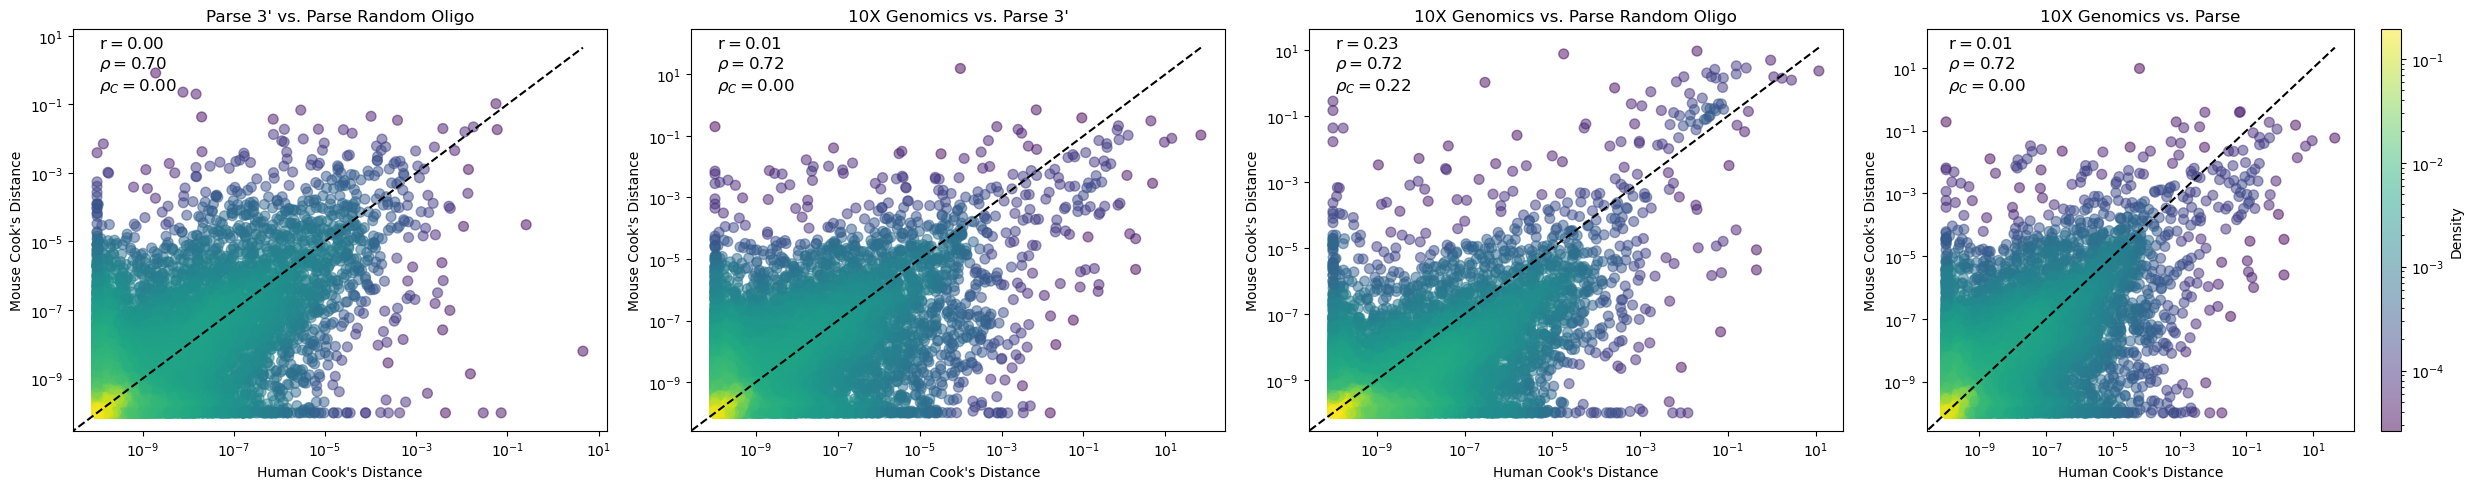

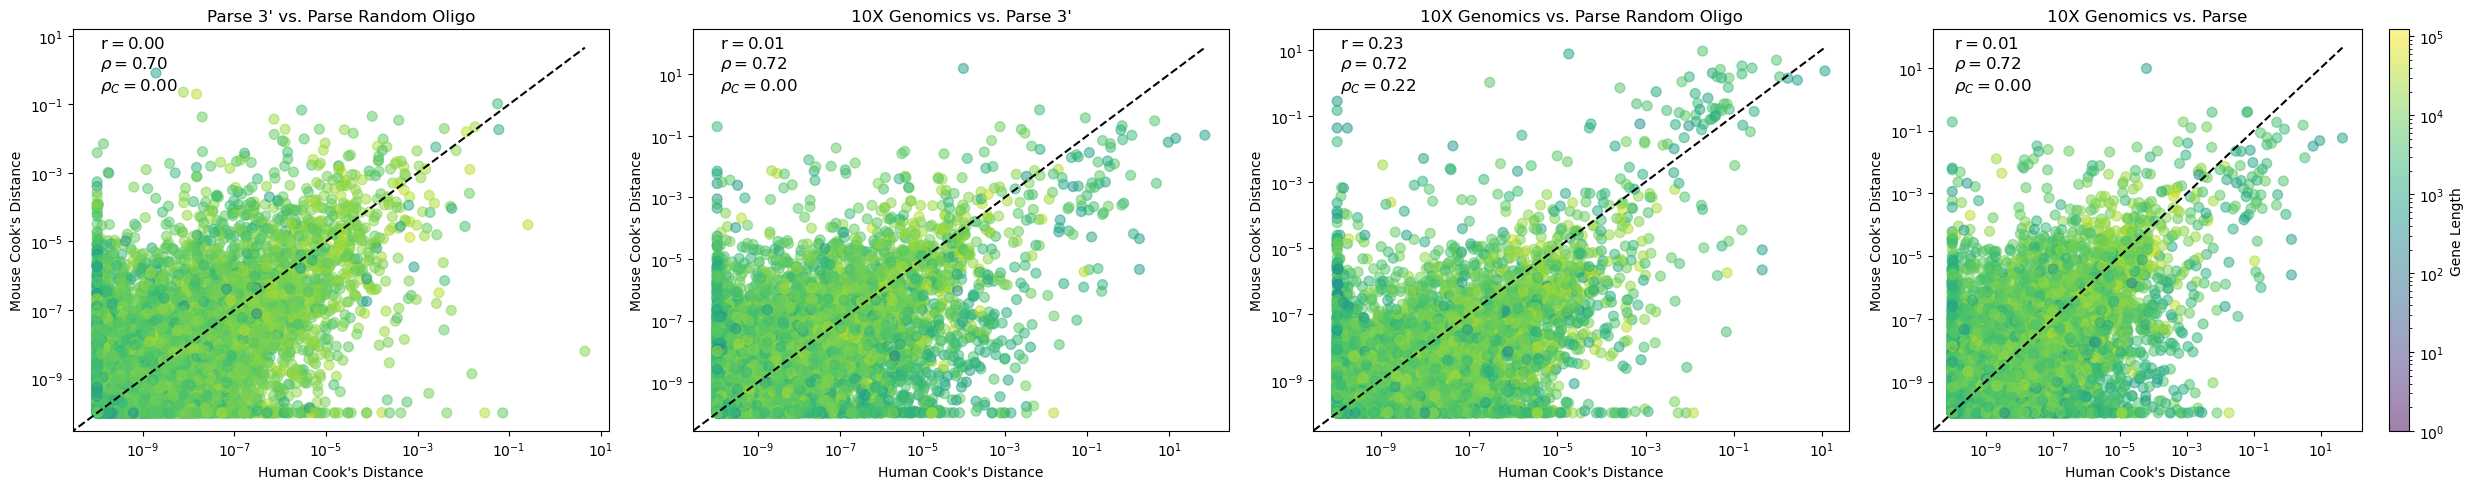

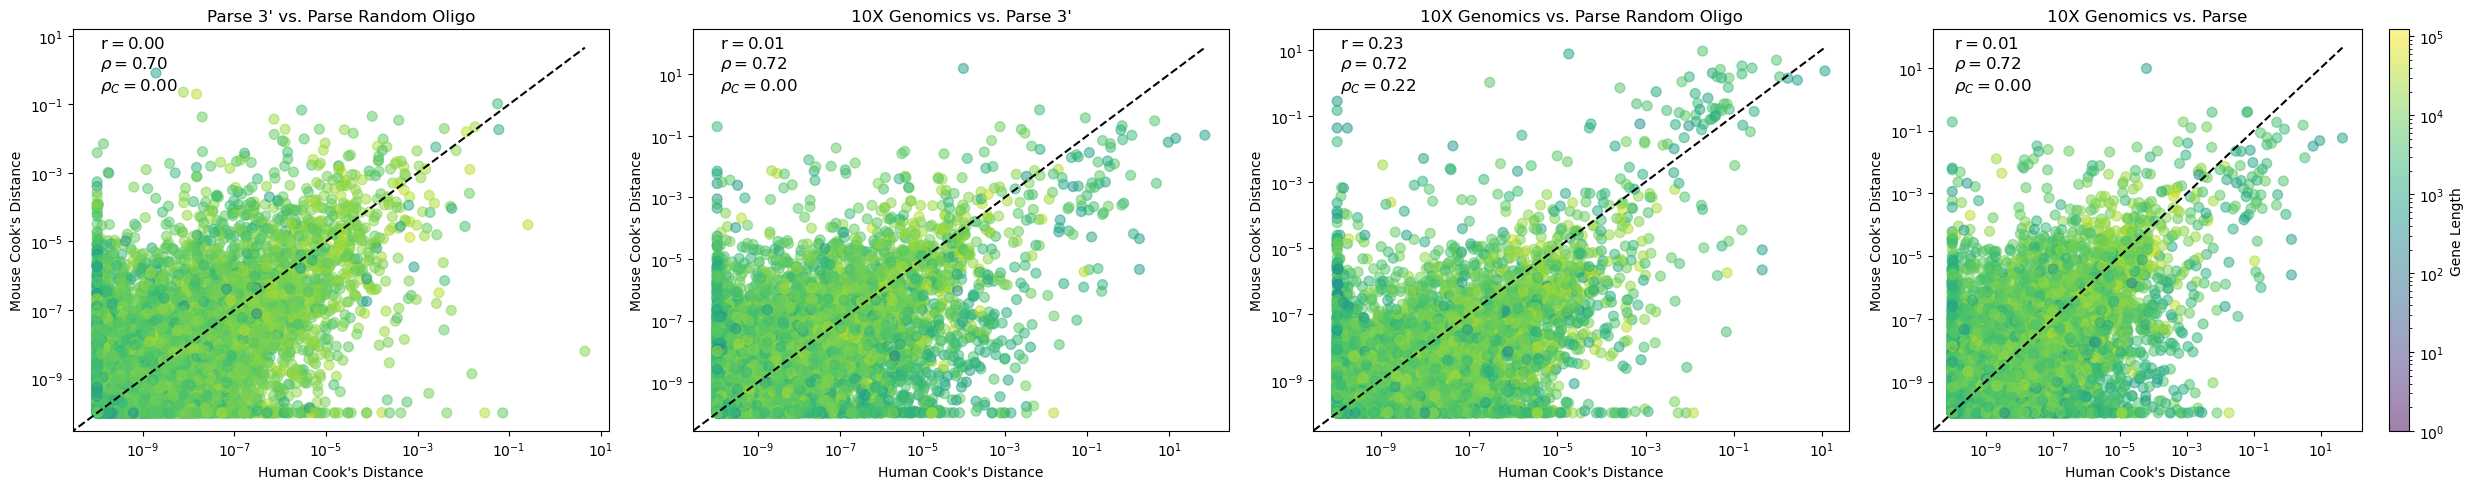

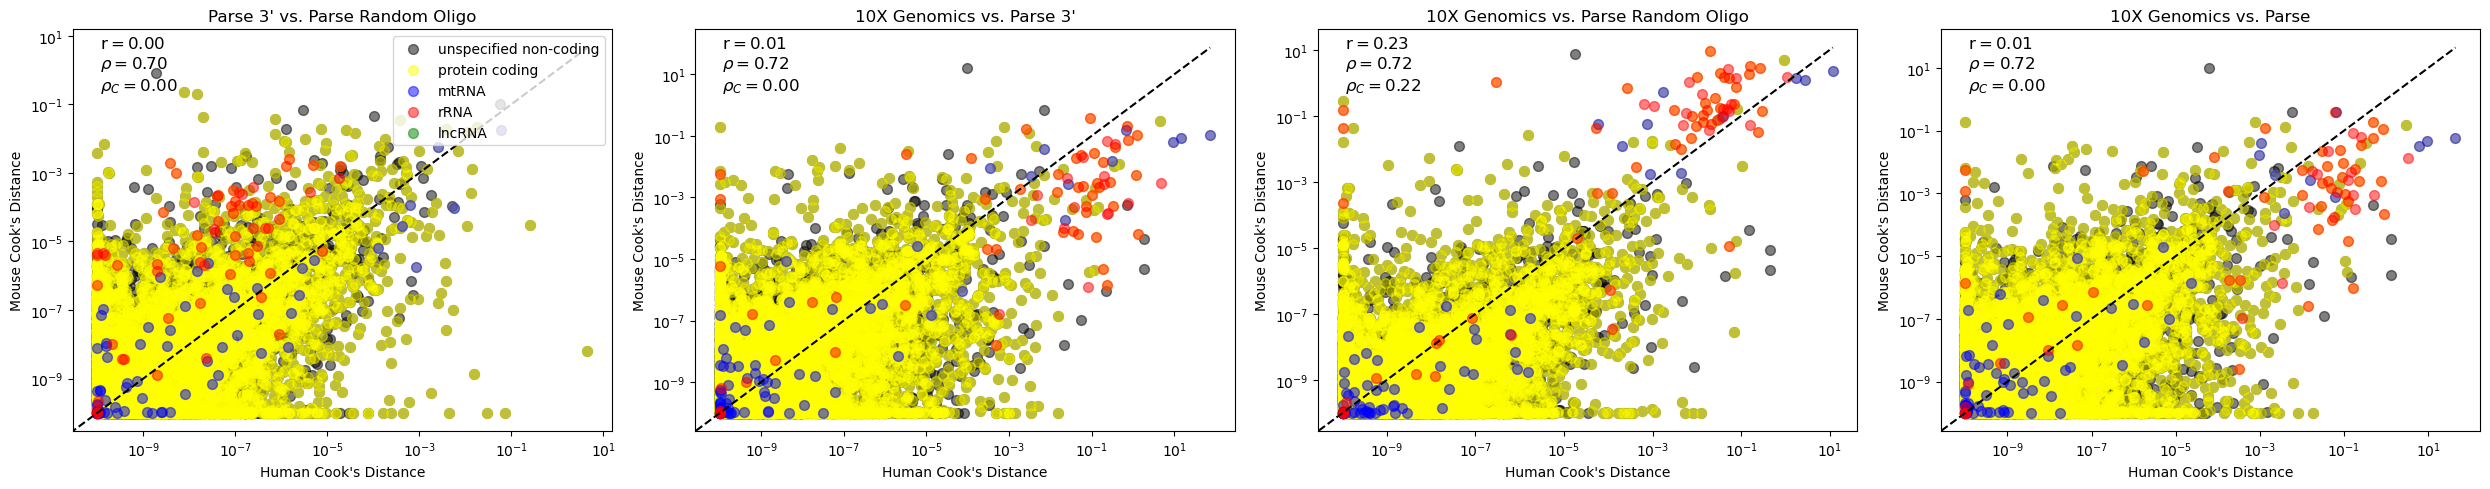

In [69]:
compareCooks(combined_df)

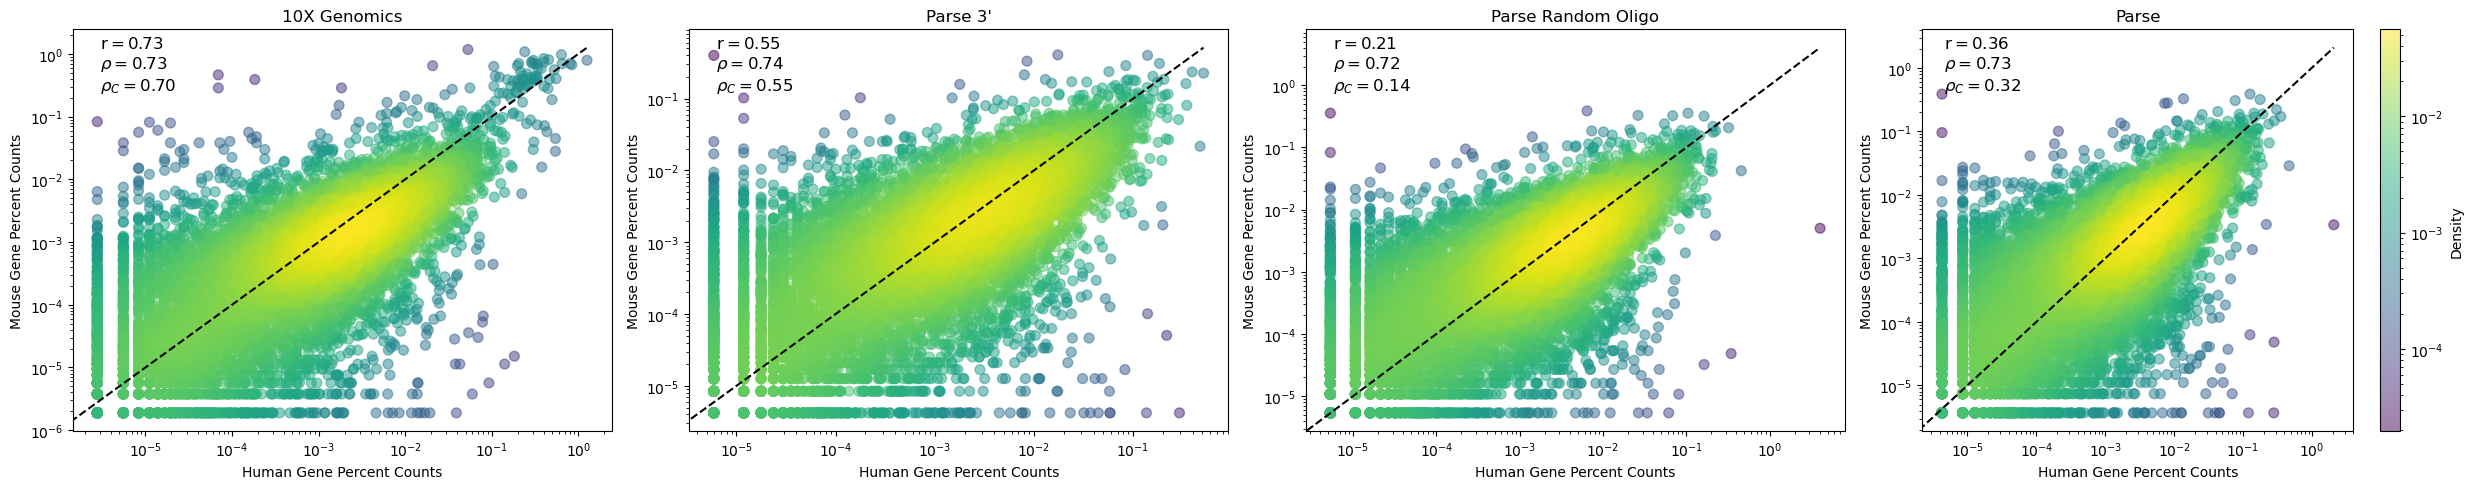

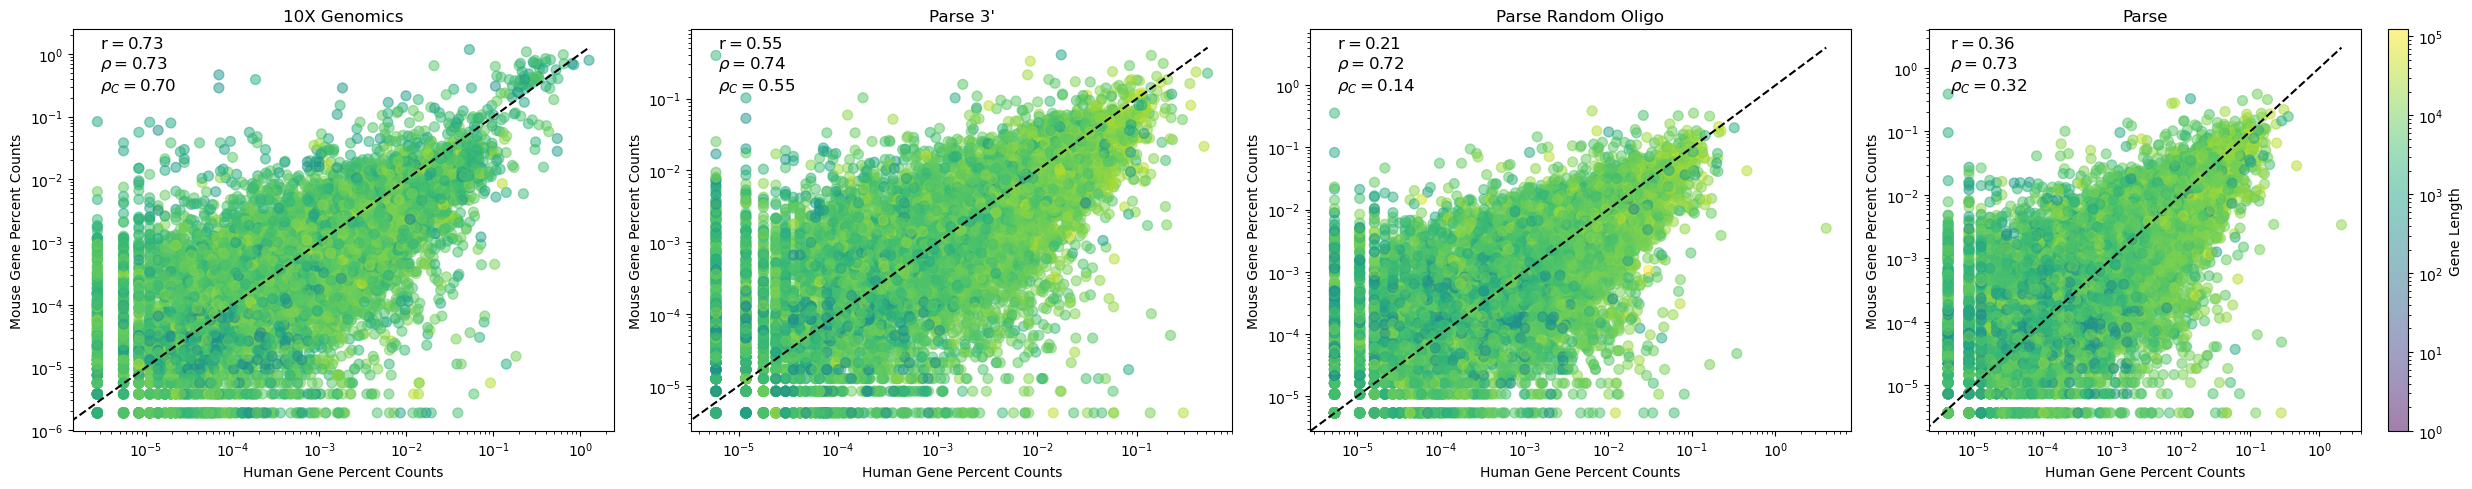

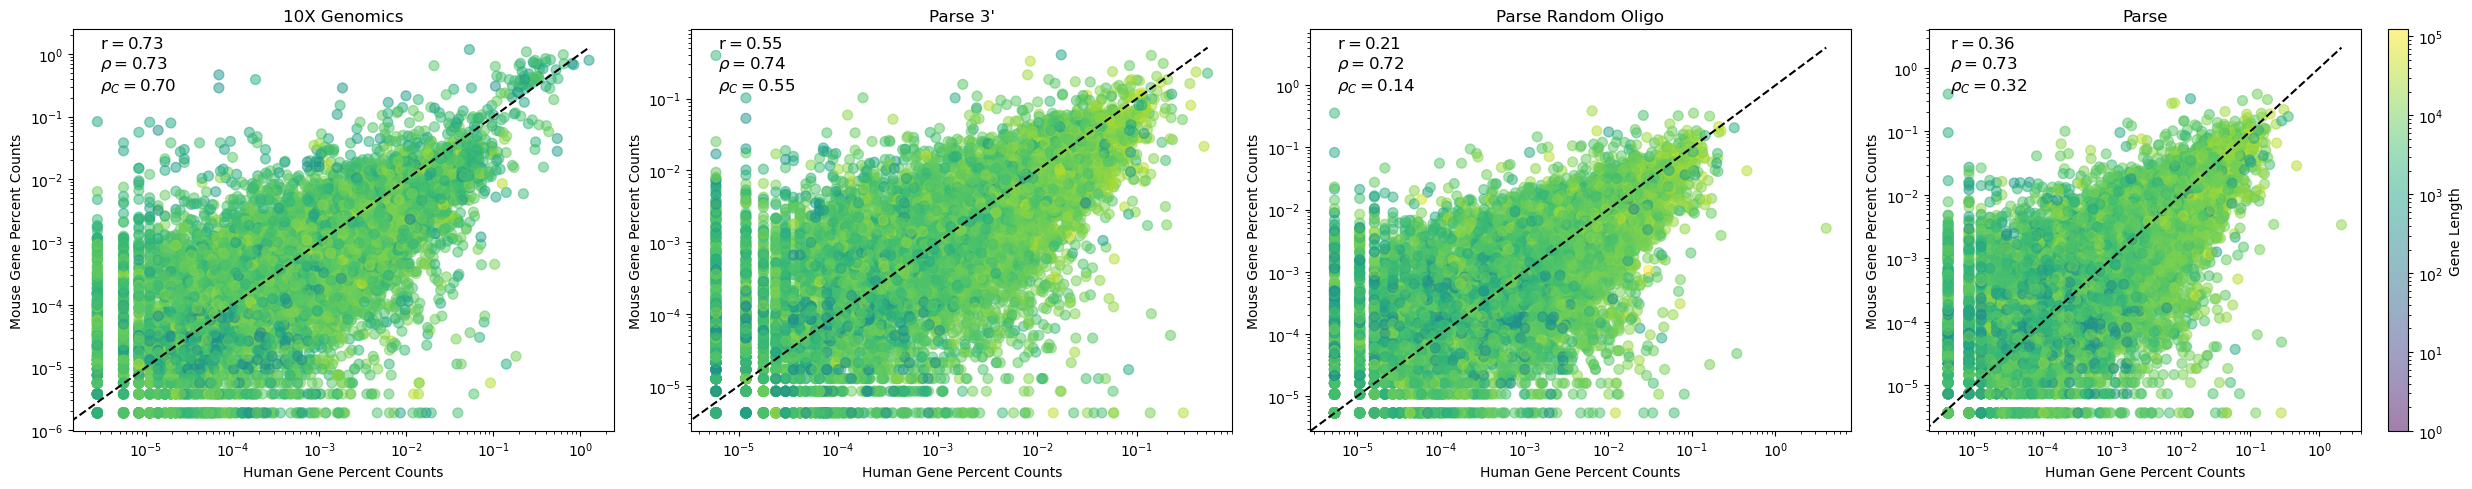

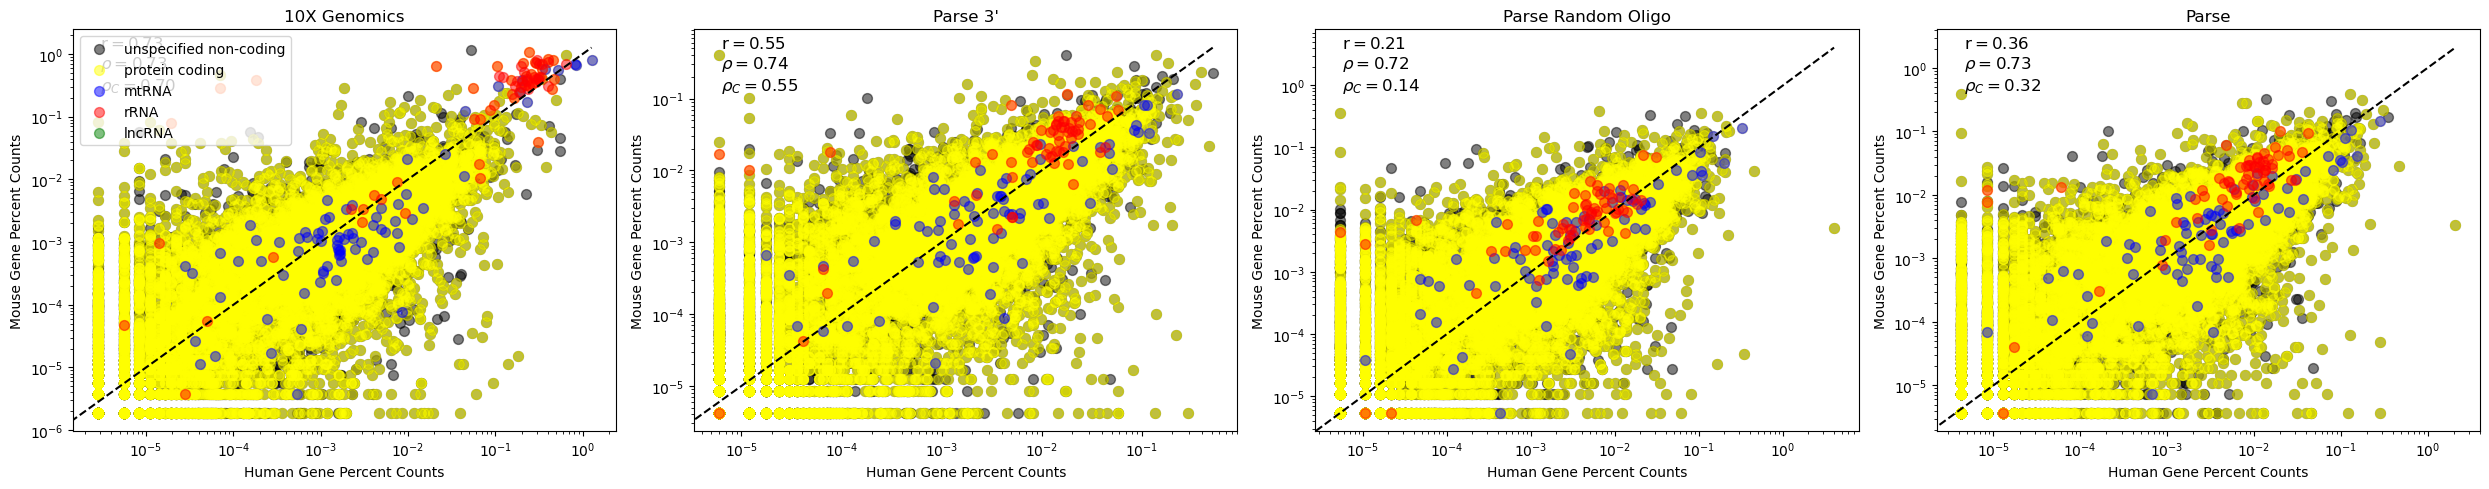

In [70]:
compareCellPercentage(combined_df)

In [83]:
mouse_n_cells = ['polyT_n_cells_mouse', 
                 'randO_n_cells_mouse', 
                 'parse_n_cells_mouse']
mouse_10x = combined_df[(combined_df[mouse_n_cells] == 0).all(axis=1)]
mouse_10x = mouse_10x[mouse_10x['10x_n_cells_mouse'] > 0]
print(len(mouse_10x))

46


In [84]:
human_n_cells = ['polyT_n_cells_human', 
                 'randO_n_cells_human', 
                 'parse_n_cells_human']
human_10x = combined_df[(combined_df[human_n_cells] == 0).all(axis=1)]
human_10x = human_10x[human_10x['10x_n_cells_mouse'] > 0]
print(len(human_10x))

14


In [86]:
ribos = combined_df[(combined_df[['10x_parse_distance_human','10x_parse_distance_mouse']] > 10e-3).all(axis=1)]
ribos = ribos[ribos['is_ribo']]

In [89]:
ribos['human_gene_name']

2496      RPS19
2541     RPL18A
2796      RPL28
3485      RPS15
6369       RPS8
6523     RPS27A
7559      RPL30
8576      RPS14
11347     RPS23
12190     RPL39
12958     RPS18
Name: human_gene_name, dtype: object